**Задание**

Необходимо реализовать алгоритм DQN. В качестве среды можно использовать классические среды (в этом случае используется полносвязная архитектура нейронной сети) или игры Atari (в этом случае используется сверточная архитектура нейронной сети).

**Описание набора данных**

In [3]:
import sys
!{sys.executable} -m pip install torch

In [4]:
!{sys.executable} -m pip install gym[classic_control]

In [5]:
import gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [6]:
# Название среды
CONST_ENV_NAME = 'Acrobot-v1'
# Использование GPU
CONST_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Элемент ReplayMemory в форме именованного кортежа
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

In [7]:
# Реализация техники Replay Memory
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        '''
        Сохранение данных в ReplayMemory
        '''
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        '''
        Выборка случайных элементов размера batch_size
        '''
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [8]:
class DQN_Model(nn.Module):

    def __init__(self, n_observations, n_actions):
        '''
        Инициализация топологии нейронной сети
        '''
        super(DQN_Model, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        '''
        Прямой проход
        Вызывается для одного элемента, чтобы определить следующее действие
        Или для batch'а во время процедуры оптимизации
        '''
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [9]:
class DQN_Agent:

    def __init__(self, env,
                 BATCH_SIZE = 128,
                 GAMMA = 0.99,
                 EPS_START = 0.9,
                 EPS_END = 0.05,
                 EPS_DECAY = 1000,
                 TAU = 0.005,
                 LR = 1e-4
                 ):
        # Среда
        self.env = env
        # Размерности Q-модели
        self.n_actions = env.action_space.n
        state, _ = self.env.reset()
        self.n_observations = len(state)
        # Коэффициенты
        self.BATCH_SIZE = BATCH_SIZE
        self.GAMMA = GAMMA
        self.EPS_START = EPS_START
        self.EPS_END = EPS_END
        self.EPS_DECAY = EPS_DECAY
        self.TAU = TAU
        self.LR = LR
        # Модели
        # Основная модель
        self.policy_net = DQN_Model(self.n_observations, self.n_actions).to(CONST_DEVICE)
        # Вспомогательная модель, используется для стабилизации алгоритма
        # Обновление контролируется гиперпараметром TAU
        # Используется подход Double DQN
        self.target_net = DQN_Model(self.n_observations, self.n_actions).to(CONST_DEVICE)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        # Оптимизатор
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.LR, amsgrad=True)
        # Replay Memory
        self.memory = ReplayMemory(10000)
        # Количество шагов
        self.steps_done = 0
        # Длительность эпизодов
        self.episode_durations = []


    def select_action(self, state):
        '''
        Выбор действия
        '''
        sample = random.random()
        eps = self.EPS_END + (self.EPS_START - self.EPS_END) * \
            math.exp(-1. * self.steps_done / self.EPS_DECAY)
        self.steps_done += 1
        if sample > eps:
            with torch.no_grad():
                # Если вероятность больше eps
                # то выбирается действие, соответствующее максимальному Q-значению
                # t.max(1) возвращает максимальное значение колонки для каждой строки
                # [1] возвращает индекс максимального элемента
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            # Если вероятность меньше eps
            # то выбирается случайное действие
            return torch.tensor([[self.env.action_space.sample()]], device=CONST_DEVICE, dtype=torch.long)


    def plot_durations(self, show_result=False):
        plt.figure(1)
        durations_t = torch.tensor(self.episode_durations, dtype=torch.float)
        if show_result:
            plt.title('Результат')
        else:
            plt.clf()
            plt.title('Обучение...')
        plt.xlabel('Эпизод')
        plt.ylabel('Количество шагов в эпизоде')
        plt.plot(durations_t.numpy())
        plt.pause(0.001)  # пауза


    def optimize_model(self):
        '''
        Оптимизация модели
        '''
        if len(self.memory) < self.BATCH_SIZE:
            return
        transitions = self.memory.sample(self.BATCH_SIZE)
        # Транспонирование batch'а
        # (https://stackoverflow.com/a/19343/3343043)
        # Конвертация batch-массива из Transition
        # в Transition batch-массивов.
        batch = Transition(*zip(*transitions))

        # Вычисление маски нефинальных состояний и конкатенация элементов batch'а
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=CONST_DEVICE, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Вычисление Q(s_t, a)
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Вычисление V(s_{t+1}) для всех следующих состояний
        next_state_values = torch.zeros(self.BATCH_SIZE, device=CONST_DEVICE)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        # Вычисление ожидаемых значений Q
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

        # Вычисление Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Оптимизация модели
        self.optimizer.zero_grad()
        loss.backward()
        # gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()


    def play_agent(self):
        '''
        Проигрывание сессии для обученного агента
        '''
        env2 = gym.make(CONST_ENV_NAME, render_mode='human')
        state = env2.reset()[0]
        state = torch.tensor(state, dtype=torch.float32, device=CONST_DEVICE).unsqueeze(0)
        done = False
        res = []
        while not done:

            action = self.select_action(state)
            action = action.item()
            observation, reward, terminated, truncated, _ = env2.step(action)
            env2.render()

            res.append((action, reward))

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=CONST_DEVICE).unsqueeze(0)

            state = next_state
            if terminated or truncated:
                done = True

        print('Данные об эпизоде: ', res)


    def learn(self):
        '''
        Обучение агента
        '''
        if torch.cuda.is_available():
            num_episodes = 600
        else:
            num_episodes = 50

        for i_episode in range(num_episodes):
            # Инициализация среды
            state, info = self.env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=CONST_DEVICE).unsqueeze(0)
            for t in count():
                action = self.select_action(state)
                observation, reward, terminated, truncated, _ = self.env.step(action.item())
                reward = torch.tensor([reward], device=CONST_DEVICE)

                done = terminated or truncated
                if terminated:
                    next_state = None
                else:
                    next_state = torch.tensor(observation, dtype=torch.float32, device=CONST_DEVICE).unsqueeze(0)

                # Сохранение данных в Replay Memory
                self.memory.push(state, action, next_state, reward)

                # Переход к следующему состоянию
                state = next_state

                # Выполнение одного шага оптимизации модели
                self.optimize_model()

                # Обновление весов target-сети
                # θ′ ← τ θ + (1 − τ )θ′
                target_net_state_dict = self.target_net.state_dict()
                policy_net_state_dict = self.policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*self.TAU + target_net_state_dict[key]*(1-self.TAU)
                self.target_net.load_state_dict(target_net_state_dict)

                if done:
                    self.episode_durations.append(t + 1)
                    self.plot_durations()
                    break

# Работа программы

C:\Users\Maria\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


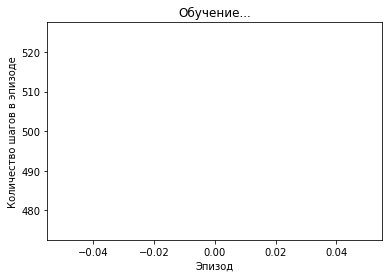

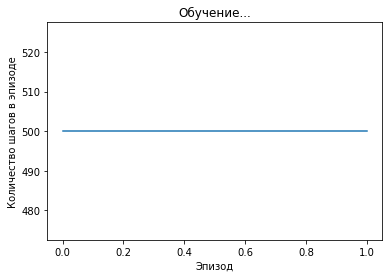

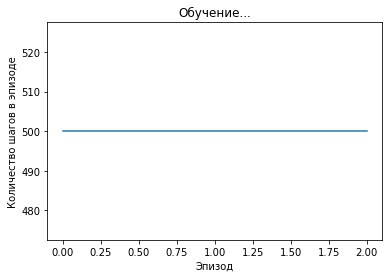

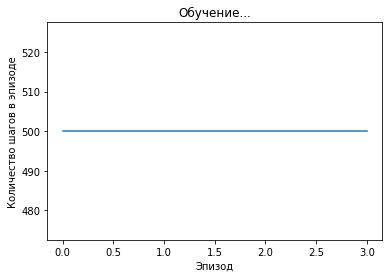

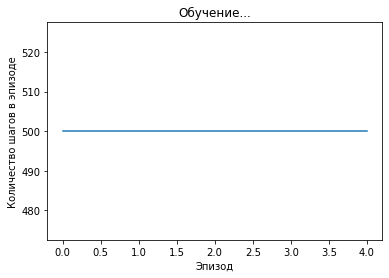

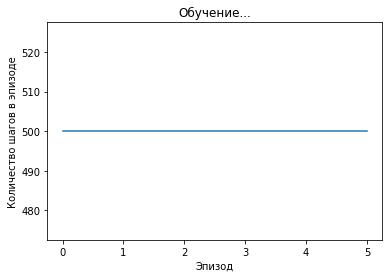

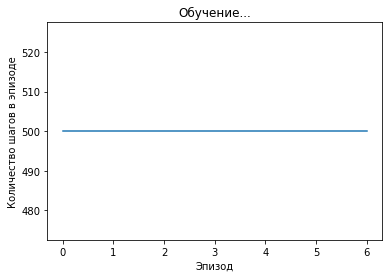

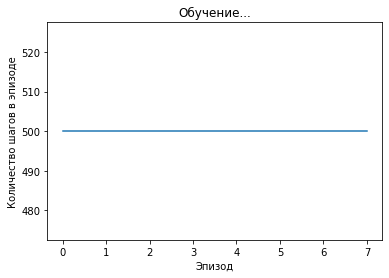

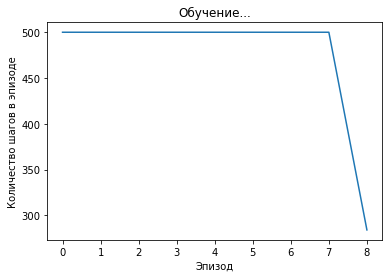

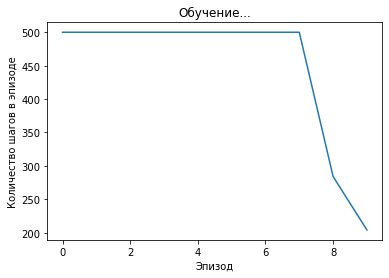

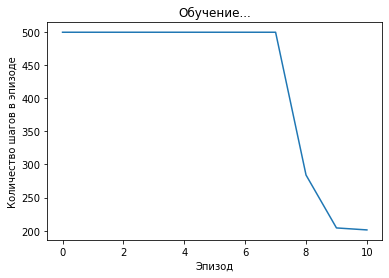

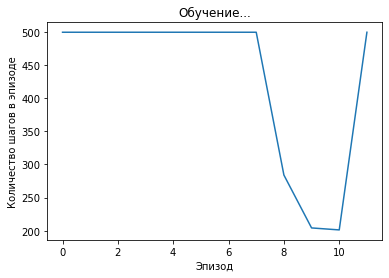

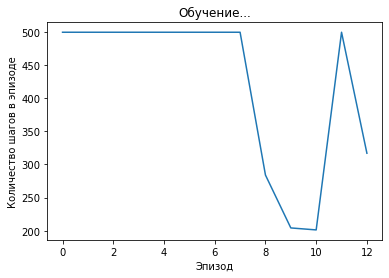

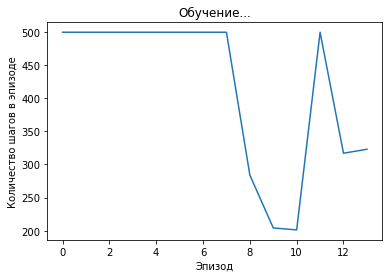

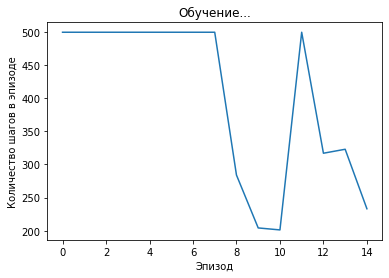

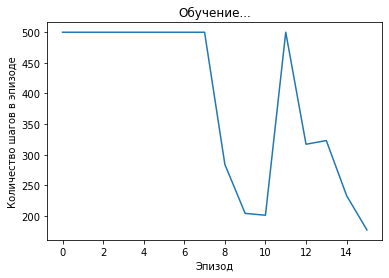

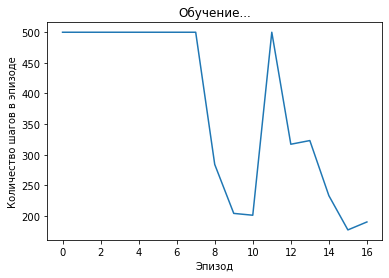

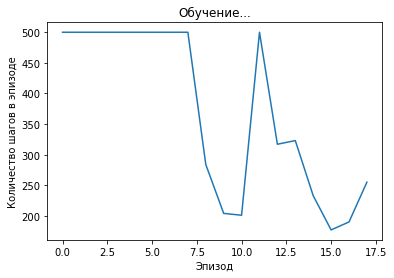

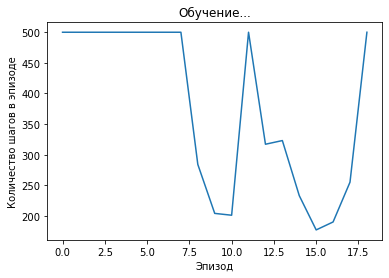

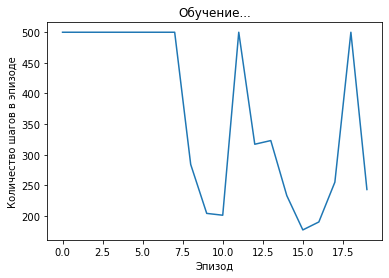

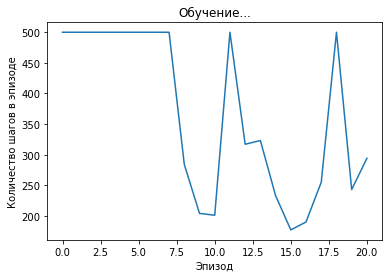

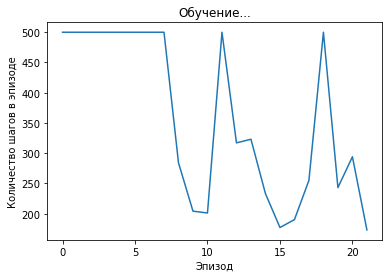

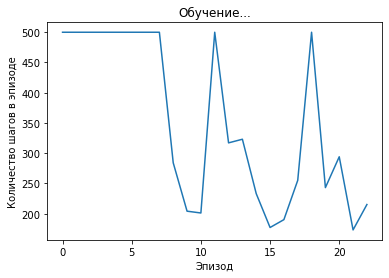

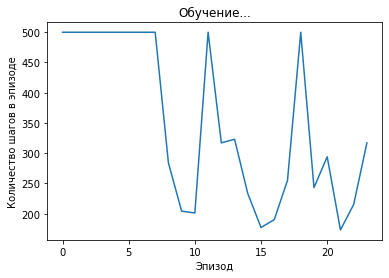

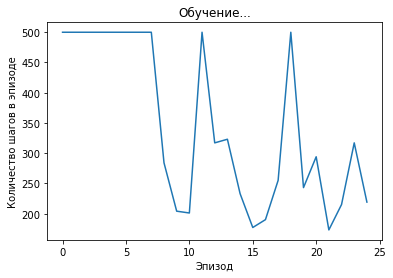

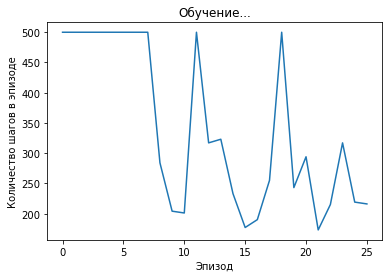

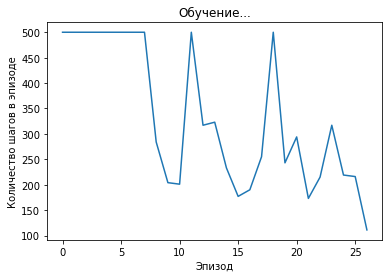

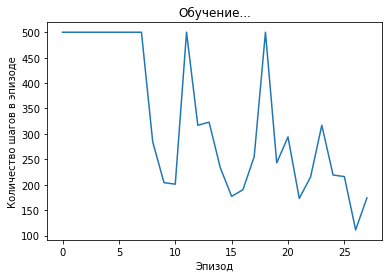

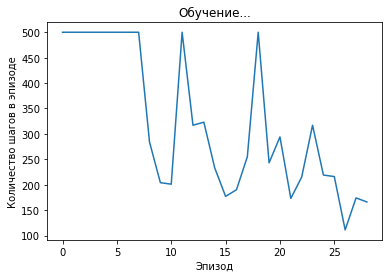

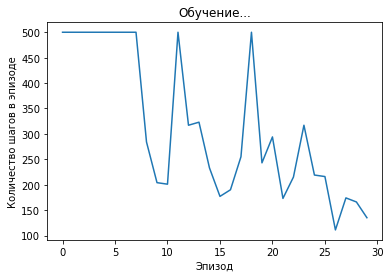

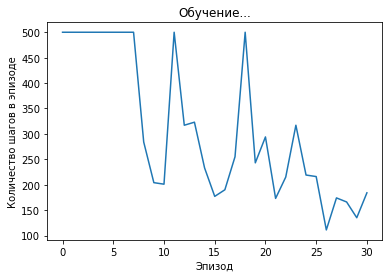

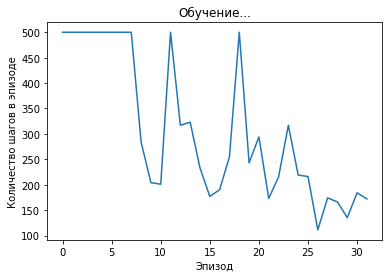

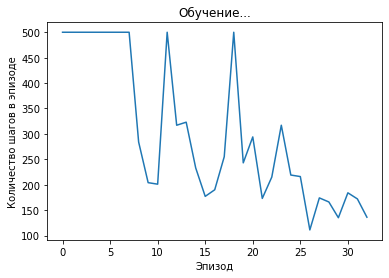

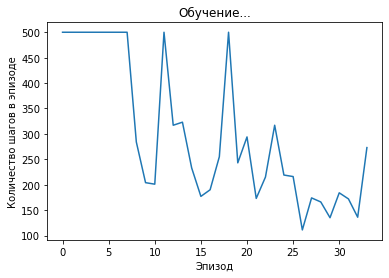

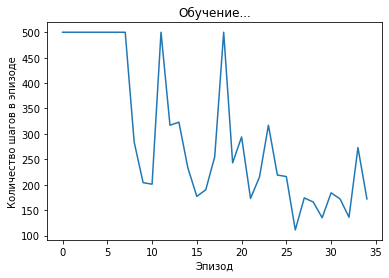

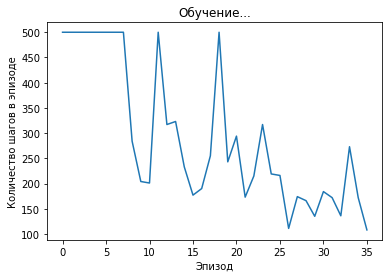

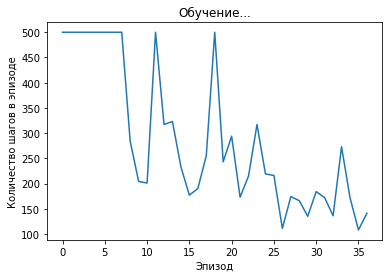

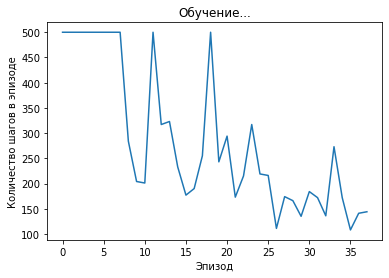

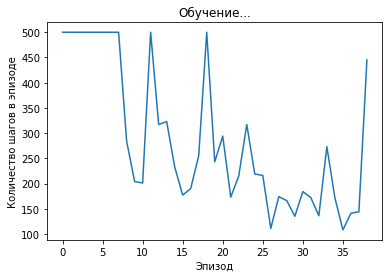

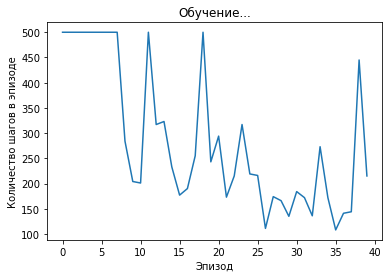

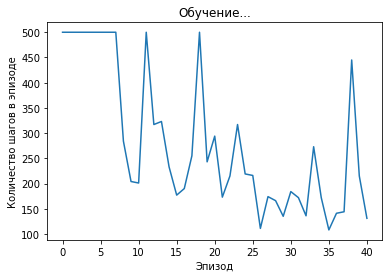

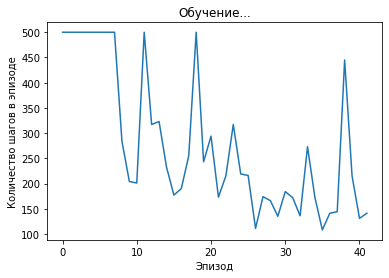

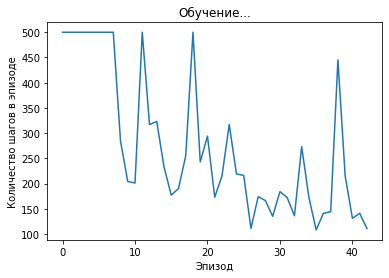

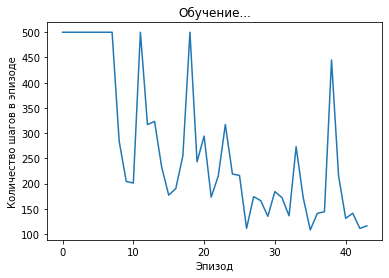

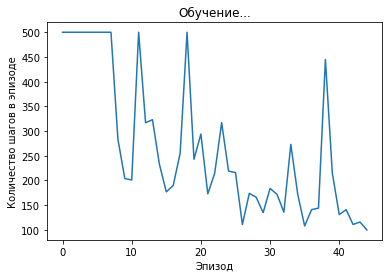

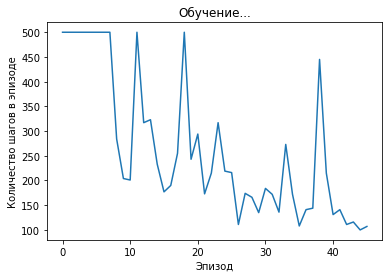

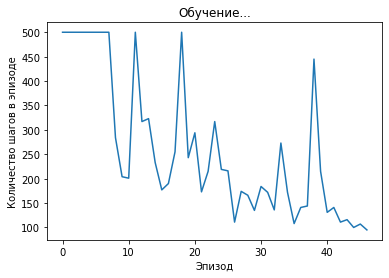

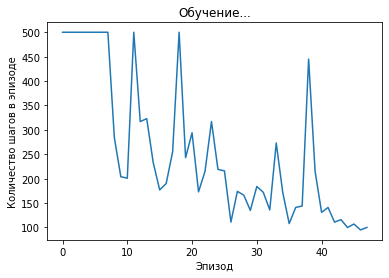

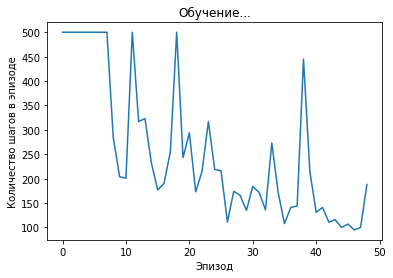

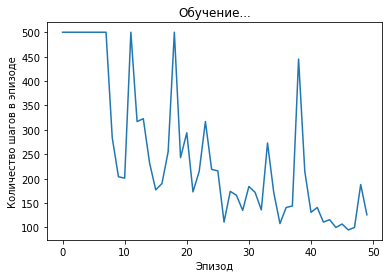

In [10]:
env = gym.make(CONST_ENV_NAME)
agent = DQN_Agent(env)
agent.learn()

In [11]:
agent.play_agent()

C:\Users\Maria\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Данные об эпизоде:  [(1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (2, -1.0), (1, -1.0), (1, -1.0), (1, -1.0), (0, -1.0), (0, -1.0), (0, -1.0), (0, -1.0), (0, -1.0), (2, -1.0), (2, -1.0), (2, -1.0), (2, -1.0), (2, -1.0), (2, -1.0), (1, -1.0), (0, -1.0), (0, -1.0), (0, -1.0), (0, -1.0), (0, -1.0), (2, -1.0), (2, -1.0), (2, -1.0), (2, -1.0), (2, -1.0), (2, -1.0), (2, -1.0), (0, -1.0), (0, -1.0), (0, -1.0), (0, -1.0), (0, -1.0), 